In [1]:
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'weight': 'bold','size':   16}
plt.rc('font', **font)
import geopy.distance as geo
import re

In [18]:
rtd_df = pd.read_csv('../data/rtd_data.csv')
# import os
# import boto3
# import pandas as pd
# import io

# # get your credentials from environment variables
# aws_id = os.environ['AWS_ACCESS_KEY_ID']
# aws_secret = os.environ['AWS_SECRET_ACCESS_KEY']

# client = boto3.client('s3'
#                       ,aws_access_key_id=aws_id
#                       ,aws_secret_access_key=aws_secret)

# bucket_name = 'rtd-on-time-departure'

# object_key = 'rtd_data.csv'
# csv_obj = client.get_object(Bucket=bucket_name, Key=object_key)

# rtd_df = pd.read_csv(io.BytesIO(csv_obj['Body'].read()), encoding='utf8')

rtd_df.shape

(1234476, 13)

In [19]:
rtd_df = rtd_df[(~rtd_df.timestamp.isnull())]
rtd_df.shape

(1234475, 13)

In [20]:
rtd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1234475 entries, 1 to 1234475
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   entity_id              1234475 non-null  object 
 1   trip_id                1234475 non-null  float64
 2   schedule_relationship  1234475 non-null  float64
 3   route_id               1234475 non-null  object 
 4   direction_id           1234475 non-null  float64
 5   vehicle_lat            1234475 non-null  float64
 6   vehicle_lng            1234475 non-null  float64
 7   bearing                1234475 non-null  float64
 8   current_status         1234475 non-null  float64
 9   timestamp              1234475 non-null  float64
 10  stop_id                1234475 non-null  float64
 11  vehicle_id             1234475 non-null  object 
 12  vehicle_label          1234475 non-null  float64
dtypes: float64(10), object(3)
memory usage: 131.9+ MB


In [21]:
char_length = []

for vehicle in rtd_df.vehicle_id.unique():
    char_length.append(len(str(vehicle)))
    
char_length

rtd_df.vehicle_label.unique()

array([1.534e+03, 1.541e+03, 3.615e+03, 3.634e+03, 3.668e+03, 3.712e+03,
       5.106e+03, 5.109e+03, 5.114e+03, 5.122e+03, 5.125e+03, 5.126e+03,
       5.160e+03, 5.174e+03, 5.182e+03, 5.184e+03, 5.187e+03, 5.236e+03,
       5.247e+03, 5.250e+03, 6.001e+03, 6.011e+03, 6.017e+03, 6.020e+03,
       6.024e+03, 6.042e+03, 6.054e+03, 6.060e+03, 6.062e+03, 6.063e+03,
       6.065e+03, 6.068e+03, 6.069e+03, 6.073e+03, 6.074e+03, 6.076e+03,
       6.084e+03, 6.086e+03, 6.092e+03, 6.095e+03, 6.101e+03, 6.104e+03,
       6.110e+03, 6.127e+03, 6.140e+03, 6.163e+03, 6.201e+03, 6.205e+03,
       6.213e+03, 6.216e+03, 6.222e+03, 6.224e+03, 6.231e+03, 6.233e+03,
       6.253e+03, 6.266e+03, 6.271e+03, 6.272e+03, 6.281e+03, 6.290e+03,
       6.297e+03, 6.302e+03, 6.307e+03, 6.308e+03, 6.313e+03, 6.323e+03,
       6.327e+03, 6.337e+03, 6.394e+03, 6.396e+03, 6.401e+03, 6.413e+03,
       6.501e+03, 6.516e+03, 9.311e+03, 9.322e+03, 9.332e+03, 9.356e+03,
       9.357e+03, 9.373e+03, 9.374e+03, 9.397e+03, 

In [24]:
# def convert_timezone_local(df, colname_list, current_timezone, local_timezone): 
#         '''
#         Converts the columns in colname_list to local timezone

#         Args:
#             colname_list (list): list of column names (strings) to convert in the RTD_df.df class. 
#                                 Values should be int for conversion
#             current_timezone (str): string of timezone that the column name currently is in
#             local_timezone (str): string of the timezone that the column name should be converted to.
#         '''
#         for column in colname_list:
#             df[column] = pd.to_datetime(df[column], unit='s').dt.tz_localize(current_timezone).dt.tz_convert(local_timezone)
        
#         return df

# rtd_df = convert_timezone_local(rtd_df, ['timestamp'], 'UTC', 'US/Mountain')
rtd_df.timestamp.dt.to_period('D').unique()

<PeriodArray>
['2021-02-15', '2021-02-16', '2021-02-17', '2021-02-18', '2021-02-19',
 '2021-02-22']
Length: 6, dtype: period[D]

In [47]:
sorted_rtd_df = rtd_df.sort_values(['vehicle_id', 'timestamp'])
sorted_rtd_df.loc[:,'departure_timestamp'] = sorted_rtd_df.groupby(['trip_id', 'vehicle_label']).timestamp.shift(-1)
sorted_rtd_df.loc[:,'departure_vehicle_lat'] = sorted_rtd_df.groupby(['trip_id', 'vehicle_label']).vehicle_lat.shift(-1)
sorted_rtd_df.loc[:,'departure_vehicle_lng'] = sorted_rtd_df.groupby(['trip_id', 'vehicle_label']).vehicle_lng.shift(-1)
sorted_rtd_df.loc[:,'next_stop_id'] = sorted_rtd_df.groupby(['trip_id', 'vehicle_label']).stop_id.shift(-1)

In [48]:
rtd_df_stops = sorted_rtd_df[~(sorted_rtd_df.stop_id == sorted_rtd_df.next_stop_id)]
rtd_df_stops = rtd_df_stops[~rtd_df_stops.next_stop_id.isnull()]

In [49]:
def join_txt_file(df, txt_file, join_type, join_columns):
        '''
        Joins a txt column to a pandas DataFrame by the join_column(s) using the type of join passed ('left', 'outer')
        
        Args:
            txt_file (str): Filepath to a text file that is separated by ','

            join_type (str): The type of join to use (Left, Outer, Inner, Full)

            join_columns (list): The columns to perform the join with
        '''
        return pd.merge(df, pd.read_csv(txt_file, delimiter=','), how=join_type, on=join_columns, suffixes=('', '_joined')) 

rtd_df_stops = join_txt_file(rtd_df_stops, '~/Documents/dsi/repos/rtd_on_time_departure/data/google_transit/routes.txt', 'left', ['route_id'])
rtd_df_stops = join_txt_file(rtd_df_stops, '~/Documents/dsi/repos/rtd_on_time_departure/data/google_transit/trips.txt', 'left', ['trip_id'])
rtd_df_stops = join_txt_file(rtd_df_stops, '~/Documents/dsi/repos/rtd_on_time_departure/data/google_transit/stops.txt', 'left', ['stop_id'])
rtd_df_stops = join_txt_file(rtd_df_stops, '~/Documents/dsi/repos/rtd_on_time_departure/data/google_transit/stop_times.txt', 'left', ['trip_id', 'stop_id'])

In [50]:
rtd_df_stops = rtd_df_stops[~(rtd_df_stops.stop_name.isnull()) & (rtd_df_stops.vehicle_lat > 0.0)]

In [52]:
final_rtd_data = rtd_df_stops.loc[:,['entity_id'
                  ,'vehicle_id'
                  ,'vehicle_label'
                  ,'trip_id'
                  ,'trip_headsign'
                  ,'route_id'
                  ,'route_type'
                  ,'route_long_name'
                  ,'route_short_name'
                  ,'route_desc'
#                   ,'current_status'
                  ,'stop_id'
                  ,'stop_name'
                  ,'stop_desc'
                  ,'vehicle_lat'
                  ,'vehicle_lng'
                  ,'stop_lat'
                  ,'stop_lon'
                  ,'departure_vehicle_lat'
                  ,'departure_vehicle_lng'
                  ,'timestamp'
                  ,'arrival_time'
                  ,'departure_timestamp'
                  ,'departure_time']]

In [54]:
def parse_codes(df, colname, code_dict):
        '''
        Converts coded integers to their real-world values given in the code_dict

        Args:
            colname (str): column name of dataframe that contains the coded values to be converted

            code_dict (dict): dictionary of code conversion where the keys are the code integers and values 
            are their corresponding real-world values.
        '''
        df[colname] = df[colname].replace(to_replace = code_dict)

        return df
    
status_dict = {0: 'incoming_at'
                  ,1: 'stopped_at'
                  ,2: 'in_transit_to'}

route_dict = {0: 'light_rail'
             ,2: 'commuter_rail'
             ,3: 'bus'}

# final_rtd_data = parse_codes(final_rtd_data, 'current_status', status_dict)
final_rtd_data = parse_codes(final_rtd_data, 'route_type', route_dict)

In [55]:
final_rtd_data.rename({'timestamp': 'arrival_timestamp'
              ,'arrival_time': 'scheduled_arrival_time'
              ,'departure_time': 'scheduled_departure_time'
              ,'vehicle_lat': 'arrival_vehicle_lat'
              ,'vehicle_lng': 'arrival_vehicle_lng'
              ,'stop_lon': 'stop_lng'}, axis=1, inplace=True)

In [56]:
def calculate_time(df, time_1, time_2, new_column):
        '''
        Calculates the time in minutes between a timestamp and a string in the format %H:%M:%S

        Args:
            time_1 (str): The name of the column with timestamp values to use for the first time

            time_2 (str): The name of the column with string values in the format %H:%M:%S to use for the second time

            new_column (str): The name of the new column created from the difference in times
        '''
        p = re.compile('00:\d{2}')
        overnight = ((df[time_2].apply(lambda x: bool(p.match(x[0:5])))) & (df[time_1].apply(lambda x: x.hour) == 23))
        df.loc[~overnight, 'day_date'] = (df[time_1].dt.to_period('D')).astype(str)
        df.loc[overnight, 'day_date'] = (df[time_1].dt.to_period('D') + np.timedelta64(1,'D')).astype(str)
        scheduled_timestamp = pd.to_datetime(df.day_date + ' ' + df[time_2])
        time_diff = df[time_1].dt.tz_localize(None) - scheduled_timestamp.apply(lambda x: pd.Timestamp(x))
        df[new_column] = round(time_diff.apply(lambda x: x.total_seconds()/60), 2)
        
        return df

    
final_rtd_data = final_rtd_data[(~final_rtd_data.departure_timestamp.isnull())
                                & (~final_rtd_data.scheduled_arrival_time.isnull()) 
                                & (~final_rtd_data.scheduled_departure_time.isnull())]

final_rtd_data = final_rtd_data.replace({'scheduled_arrival_time': {r'^24':'00'
                                                                   ,r'^25':'00'}
                                        ,'scheduled_departure_time': {r'^24':'00'
                                                                   ,r'^25':'00'}
                                        }, regex=True)

final_rtd_data = calculate_time(final_rtd_data, 'arrival_timestamp', 'scheduled_arrival_time', 'minutes_to_arrival')
final_rtd_data = calculate_time(final_rtd_data, 'departure_timestamp', 'scheduled_departure_time', 'minutes_since_departure')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1104: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1104: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [57]:
def calculate_distance(df, point_1_lat, point_1_lng, point_2_lat, point_2_lng, new_column):
        '''
        Calculates the distance between two points in meters given their lat/lng

        Args: 
            point_1_lat (str): The name of the column with the first points latitudes

            point_1_lng (str): The name of the column with the first points longitudes

            point_2_lat (str): The name of the column with the second points latitudes

            point_2_lng (str): The name of the column with the second points longitudes

            new_column (str): The name of the new column created from the lat/lng points
        '''
        point_1 = list(zip(df[point_1_lat], df[point_1_lng]))
        point_2 = list(zip(df[point_2_lat], df[point_2_lng]))
        
        df[new_column] = [round(geo.distance(point_1, point_2).m,2) if (~pd.isnull(point_2[0])) & (point_1[0] > 0) else np.nan for point_1, point_2 in zip(point_1, point_2)]
        
        return df

final_rtd_data = calculate_distance(final_rtd_data, 'arrival_vehicle_lat', 'arrival_vehicle_lng', 'stop_lat', 'stop_lng', 'meters_to_arrival')
final_rtd_data = calculate_distance(final_rtd_data, 'departure_vehicle_lat', 'departure_vehicle_lng', 'stop_lat', 'stop_lng', 'meters_since_departure')

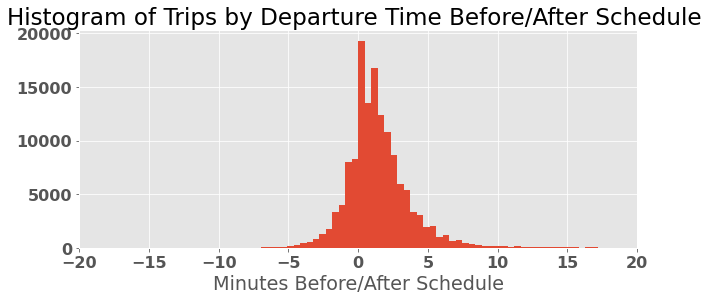

In [58]:
fig, ax = plt.subplots(figsize=(10,4))

ax.hist(final_rtd_data.minutes_since_departure, bins=250)
ax.set_xlabel('Minutes Before/After Schedule')
ax.set_title('Histogram of Trips by Departure Time Before/After Schedule ')
_ = plt.xlim((-20,20))

In [59]:
(1 - final_rtd_data[(final_rtd_data.minutes_since_departure <= -20) | (final_rtd_data.minutes_since_departure >= 20)].minutes_since_departure.size / final_rtd_data.minutes_since_departure.size) * 100

99.86733766889212